- Haben die sinnvolle total scores, idelta scores und rmsds?
- Kann man die sdfs laden? 
- Sind alle ergebnisse im zarr store plausibel? ein paar example cases anschauen und ueberlegen ob man die nicht automatisch alle testen kann

In [1]:
import zarr
from pdbbind_dock import PDBresult

store = zarr.open('full_test.zarr', 'r')
pdb_entry = PDBresult( store, '1a0t' )
pose_relax = pdb_entry.get_complex('pose_relax')
print(pose_relax.idelta_score)

34.46651930813357


docking_perturb_pose_relax_ligaway ist der letzte Prozess

In [2]:
from tqdm import tqdm

failed_keys = []
half_finished = []
successful_keys = []
ideltas = []
rmsds = []
total_scores = []

for key in tqdm(store.keys()):
    pdb_entry = PDBresult( store, key )
    if pdb_entry.healthy:
        try:
            run = pdb_entry.get_run('docking_perturb_pose_relax_ligaway', 0)
        except KeyError:
            half_finished.append(key)
            continue
        ideltas.append(run.idelta_score)
        rmsds.append(run.rmsd_to_input)
        total_scores.append(run.total_score)
        successful_keys.append(key)
    else:
        failed_keys.append(key)

100%|██████████| 11518/11518 [00:55<00:00, 206.85it/s]


In [3]:
len(failed_keys)

58

In [4]:
len(half_finished)

22

In [5]:
import numpy as np

ideltas = np.array(ideltas)
rmsds = np.array(rmsds)
total_scores = np.array(total_scores)
successful_keys = np.array(successful_keys)

In [6]:
pos_ideltas = ideltas[ideltas > 0]
neg_ideltas = ideltas[ideltas <= 0]

print(len(pos_ideltas), len(neg_ideltas))

1108 10330


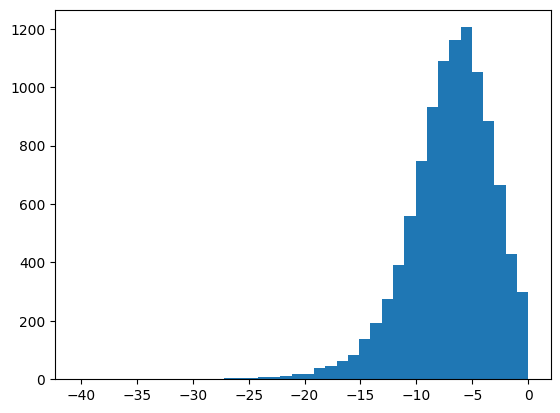

In [7]:
from matplotlib import pyplot as plt

plt.hist(neg_ideltas, bins=40)
plt.show()

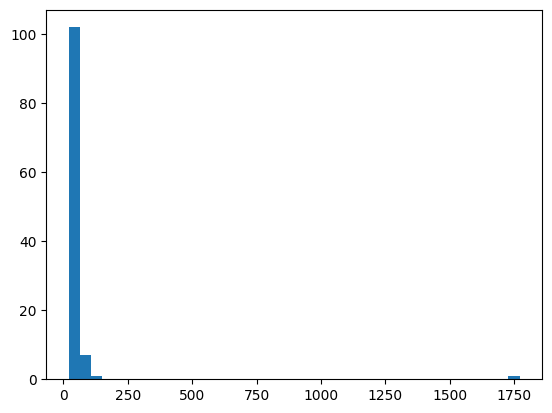

In [8]:
plt.hist(pos_ideltas[pos_ideltas > 20], bins=40)
plt.show()

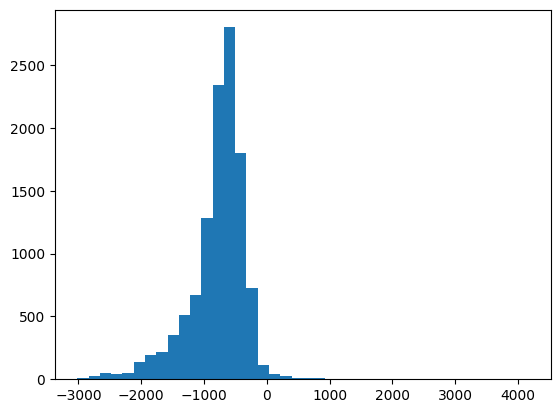

In [9]:
plt.hist(total_scores, bins=40)
plt.show()

In [10]:
len(total_scores[total_scores > 0])

126

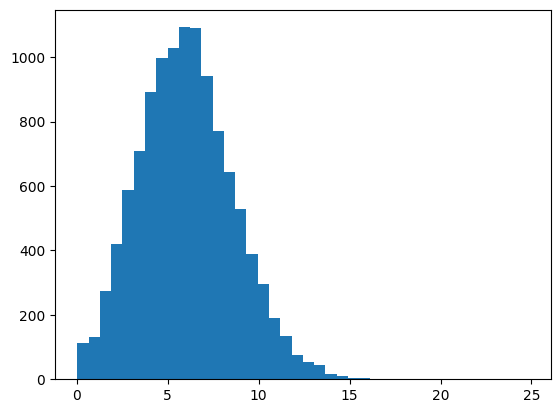

In [11]:
plt.hist(rmsds, bins=40)
plt.show()

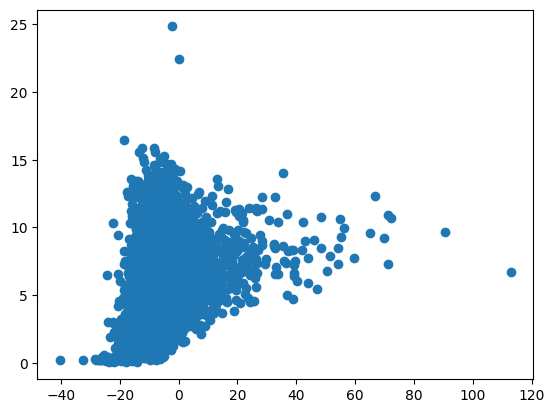

In [12]:
plt.scatter(ideltas[ideltas < 1000], rmsds[ideltas < 1000])
plt.show()

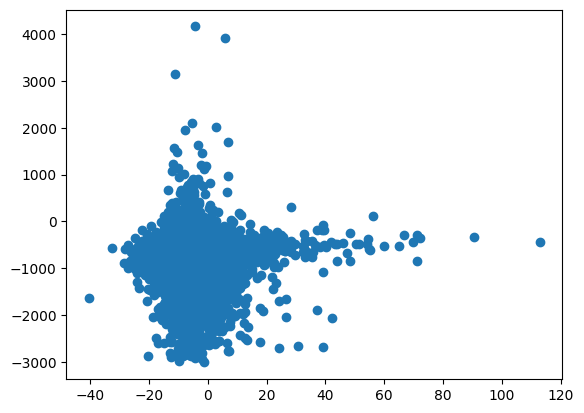

In [13]:
plt.scatter(ideltas[ideltas < 1000], total_scores[ideltas < 1000])
plt.show()

In [14]:
print(successful_keys[total_scores > 2500])
print(successful_keys[ideltas > 80])

['2a5c' '2ypi' '3ncq']
['1k22' '1k6v' '4inb']


In [15]:
for key in np.concatenate([successful_keys[total_scores > 2500], successful_keys[ideltas > 80]]):
    pdb_entry = PDBresult( store, key )
    run = pdb_entry.get_run('docking_perturb_pose_relax_ligaway', 0)
    run.write_pdb('test_out/' + key + '.pdb')
    run.write_mol('test_out/' + key + '.sdf')
    pose = pdb_entry.get_complex('pose')
    pose.write_pdb('test_out/' + key + '_orig.pdb')
    pose.write_mol('test_out/' + key + '_orig.sdf')

All results seem reasonable and I am confident to continue
- check if rdkit mols can be loaded for all results
- check the failed structures if there is any reason (like size) and at which point did they fail

In [16]:
from load_ligand import molfrommolblock
from rdkit import Chem

no_san_mol = []

for key in tqdm(store.keys()):
    try:
        pdb_entry = PDBresult( store, key )
        molblock = pdb_entry.sanitized_molblock
        mol = molfrommolblock(molblock)
        Chem.SanitizeMol(mol)
    except AttributeError:
        no_san_mol.append(key)

100%|██████████| 11518/11518 [00:40<00:00, 280.99it/s]


In [17]:
len(no_san_mol)

58

In [18]:
for key in no_san_mol:
    if key not in failed_keys:
        print(key)

In [ ]:
from Runner import Runner
from pyrosetta import *

pyrosetta.init(options='-in:auto_setup_metals -ex1 -ex2 -restore_pre_talaris_2013_behavior true -out:levels all:100', silent=True)

for key in no_san_mol:
    print(key)
    r = Runner(
        'pdbbind_2020plus/', 
        key, 
        ['xml_protocols/docking_std.xml'], 
        zarr_path='test.zarr'
    )

    # dock
    r.run(
        n_relax=0, 
        n_relax_ligaway=0, 
        n_dock=1
    )

1dmb
Loading protocol xml_protocols/docking_std.xml as docking_std
[Warning] Trying to load a score function called "hard_rep" from this xml protocol. It will overwrite the previously loaded score function and will be used to score everything outside of protocols. This behaviour might be undesired.
Found cleaned sdf in results, skip loading pdbbind original for pose
Found generated structure pose in results.
Map between rdkit and rosetta atoms exists, skipping generation.
Found cleaned sdf in results, skip loading pdbbind original for pose_relax
Found generated structure pose_relax in results.
Map between rdkit and rosetta atoms exists, skipping generation.
Found cleaned sdf in results, skip loading pdbbind original for pose_relax_ligaway
Found generated structure pose_relax_ligaway in results.
Map between rdkit and rosetta atoms exists, skipping generation.
Start processing pose: pose
Found entry in loaded results. Skip processing of pose
Start processing pose: pose_relax
Found entry 

[17:08:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


core.io.pdb.HeaderInformation: [ ERROR ] Malformed Compound record found: ' 1FTK_PROTEIN'
Found cleaned sdf in results, skip loading pdbbind original for pose_relax
Found cleaned sdf in results, skip loading pdbbind original for pose_relax_ligaway
Start processing pose: pose
	Saved total score: -649.5214
	Saved interface delta score: -13.8244
	Saved 25 raw delta Rosetta energy terms
	Saved 25 raw Rosetta energy terms
	RMSD to crystall structure: 0.0000
	No constraints were added to pose.
	Processing this pose took 0.0023 minutes
Start processing pose: pose_relax
	Saved total score: -649.5214
	Saved interface delta score: -13.8244
	Saved 25 raw delta Rosetta energy terms
	Saved 25 raw Rosetta energy terms
	RMSD to crystall structure: 0.0000
	No constraints were added to pose.
	Processing this pose took 0.0021 minutes
Start processing pose: pose_relax_ligaway
	Saved total score: -635.6970
	Saved interface delta score: 0.0000
	Saved 25 raw delta Rosetta energy terms
	Saved 25 raw Rosetta 